# **_Machine Learning Model Training_**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import time
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

## **_Data Loading_**

In [2]:
df = pd.read_csv('../data/happiness_clean_data.csv')

In [3]:
df.head()

,country,happiness_rank,happiness_score,gdp_per_capita,social_support,life_expectancy,freedom,corruption,generosity,year,region
0,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2015,Western Europe
1,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2015,Western Europe
2,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2015,Western Europe
3,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2015,Western Europe
4,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2015,North America


## **_Preprocessing_**

In [4]:
df = df.drop(columns=['country', 'happiness_rank', 'year'])

categorical_features = ['region']
numeric_features = ['gdp_per_capita', 'social_support', 'life_expectancy', 'freedom', 'corruption']
target = 'happiness_score'

## **_Data Splitting_**

In [5]:
X = df.drop(columns=['happiness_score'], axis=1)
y = df[target]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1425)

## **_Model Training_**

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [8]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Random Forest': RandomForestRegressor(random_state=1425),
    'XGBoost': XGBRegressor(random_state=1425),
    'CatBoost': CatBoostRegressor(random_state=1425, verbose=0)
}

In [9]:
cv = KFold(n_splits=5, shuffle=True, random_state=1425)

scoring = {
    'r2': 'r2',
    'rmse': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'mae': make_scorer(mean_absolute_error)
}


metrics = []

for name, model in models.items():
    print(f"Training Model: {name}")
    
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', model)
    ])
    
    start = time.time()
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
    elapsed = time.time() - start

    metrics.append({
        'Model': name,
        'R2': round(np.mean(scores['test_r2']), 4),
        'RMSE': round(np.mean(scores['test_rmse']), 4),
        'MAE': round(np.mean(scores['test_mae']), 4),
        'Time (s)': round(elapsed, 2)
    })

Training Model: Linear Regression
Training Model: Ridge Regression
Training Model: Random Forest
Training Model: XGBoost
Training Model: CatBoost


In [10]:
results_df = pd.DataFrame(metrics).sort_values(by='R2', ascending=False)

print("\nModel Results:")
results_df.head()


Model Results:


,Model,R2,RMSE,MAE,Time (s)
4,CatBoost,0.8650,0.4112,0.3193,5.35
2,Random Forest,0.8379,0.4493,0.3470,1.32
3,XGBoost,0.8323,0.4571,0.3537,0.84
0,Linear Regression,0.8082,0.4904,0.3714,0.10
1,Ridge Regression,0.8080,0.4906,0.3716,0.06


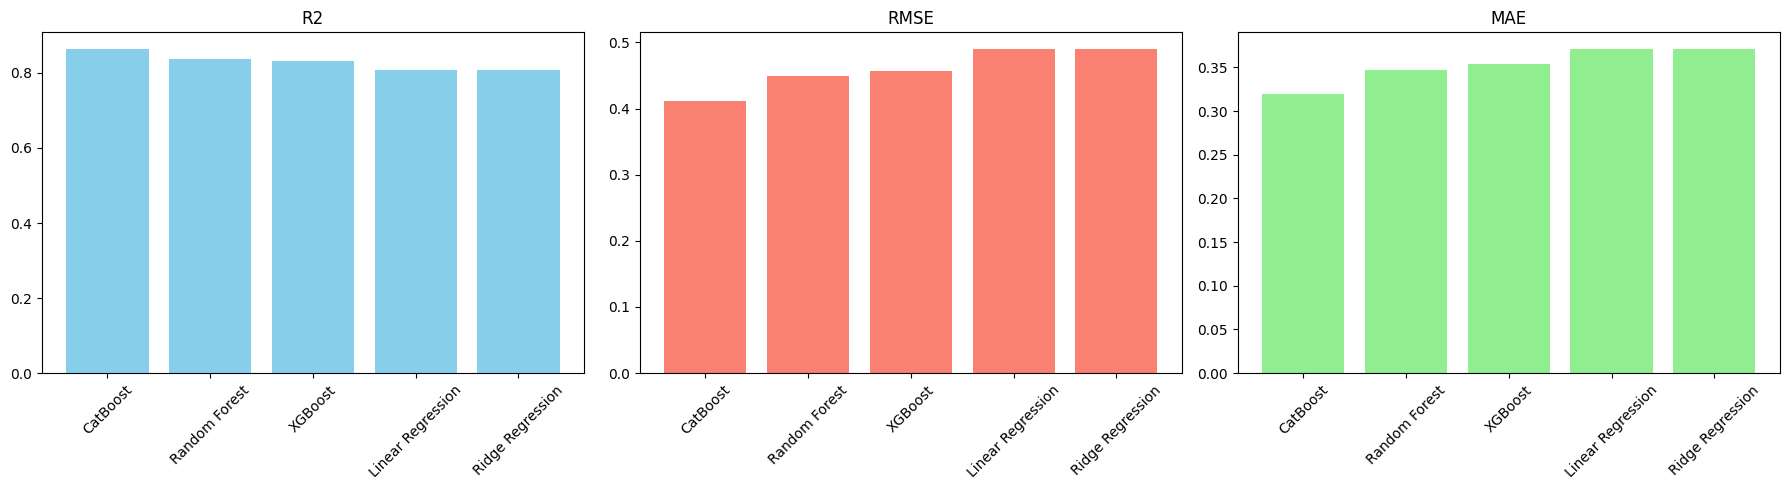

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

metrics_names = ['R2', 'RMSE', 'MAE']
colors = ['skyblue', 'salmon', 'lightgreen']

for i, metric in enumerate(metrics_names):
    axs[i].bar(results_df['Model'], results_df[metric], color=colors[i])
    axs[i].set_title(metric)
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [12]:
pipeline_cb = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', CatBoostRegressor(verbose=False))
])

pipeline_cb.fit(X_train, y_train);

In [13]:
y_pred_test = pipeline_cb.predict(X_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"\nEVALUACIÓN FINAL en el 20% de TEST:")
print(f" R2: {r2_test:.4f}")
print(f" MAE: {mae_test:.4f}")
print(f" RMSE: {rmse_test:.4f}")


EVALUACIÓN FINAL en el 20% de TEST:
 R2: 0.8566
 MAE: 0.3151
 RMSE: 0.4214


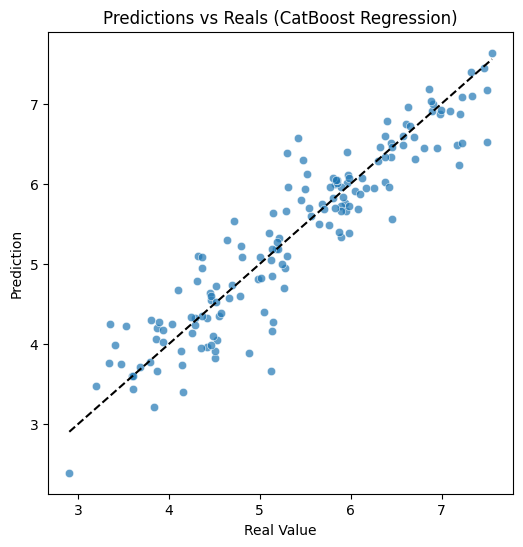

In [17]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.7)
plt.xlabel("Real Value")
plt.ylabel("Prediction")
plt.title("Predictions vs Reals (CatBoost Regression)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.show()

In [16]:
joblib.dump(pipeline_cb, '../models/trained_model.pkl')

print("Modelo fue guardado como 'trained_model.pkl'")

Modelo fue guardado como 'trained_model.pkl'
